In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


$
Setup\;python\;environment\;and\;change\;the \;current\;working\;directory
$

In [0]:
!pip install torch torchvision
!pip install Pillow==4.0.0
%mkdir -p /content/cs6360/a2/
%cd /content/cs6360/a2

In [0]:
# adapted from 
# https://github.com/fchollet/keras/blob/master/keras/datasets/cifar10.py

import os
from six.moves.urllib.request import urlretrieve
import tarfile
import numpy as np
import pickle
import sys
import PIL
from PIL import Image


def get_file(fname,
             origin,
             untar=False,
             extract=False,
             archive_format='auto',
             cache_dir='data'):
    datadir = os.path.join(cache_dir)
    if not os.path.exists(datadir):
        os.makedirs(datadir)

    if untar:
        untar_fpath = os.path.join(datadir, fname)
        fpath = untar_fpath + '.tar.gz'
    else:
        fpath = os.path.join(datadir, fname)
    
    print(fpath)
    if not os.path.exists(fpath):
        print('Downloading data from', origin)

        error_msg = 'URL fetch failure on {}: {} -- {}'
        try:
            try:
                urlretrieve(origin, fpath)
            except URLError as e:
                raise Exception(error_msg.format(origin, e.errno, e.reason))
            except HTTPError as e:
                raise Exception(error_msg.format(origin, e.code, e.msg))
        except (Exception, KeyboardInterrupt) as e:
            if os.path.exists(fpath):
                os.remove(fpath)
            raise

    if untar:
        if not os.path.exists(untar_fpath):
            print('Extracting file.')
            with tarfile.open(fpath) as archive:
                archive.extractall(datadir)
        return untar_fpath

    if extract:
        _extract_archive(fpath, datadir, archive_format)

    return fpath



def load_batch(fpath, label_key='labels'):
    """Internal utility for parsing CIFAR data.
    # Arguments
        fpath: path the file to parse.
        label_key: key for label data in the retrieve
            dictionary.
    # Returns
        A tuple `(data, labels)`.
    """
    f = open(fpath, 'rb')
    if sys.version_info < (3,):
        d = pickle.load(f)
    else:
        d = pickle.load(f, encoding='bytes')
        # decode utf8
        d_decoded = {}
        for k, v in d.items():
            d_decoded[k.decode('utf8')] = v
        d = d_decoded
    f.close()
    data = d['data']
    labels = d[label_key]

    data = data.reshape(data.shape[0], 3, 32, 32)
    return data, labels

def load_cifar10(transpose=False):
    """Loads CIFAR10 dataset.
    # Returns
        Tuple of Numpy arrays: `(x_train, y_train), (x_test, y_test)`.
    """
    dirname = 'cifar-10-batches-py'
    origin = 'http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
    path = get_file(dirname, origin=origin, untar=True)

    num_train_samples = 50000

    x_train = np.zeros((num_train_samples, 3, 32, 32), dtype='uint8')
    y_train = np.zeros((num_train_samples,), dtype='uint8')

    for i in range(1, 6):
        fpath = os.path.join(path, 'data_batch_' + str(i))
        data, labels = load_batch(fpath)
        x_train[(i - 1) * 10000: i * 10000, :, :, :] = data
        y_train[(i - 1) * 10000: i * 10000] = labels

    fpath = os.path.join(path, 'test_batch')
    x_test, y_test = load_batch(fpath)

    y_train = np.reshape(y_train, (len(y_train), 1))
    y_test = np.reshape(y_test, (len(y_test), 1))

    if transpose:
        x_train = x_train.transpose(0, 2, 3, 1)
        x_test = x_test.transpose(0, 2, 3, 1)
    return (x_train, y_train), (x_test, y_test)


$
Download\;CIFAR\;datasets\;and\;other\;related \;files
$

In [0]:
colours_fpath = get_file(fname='colours', 
                         origin='http://www.cs.toronto.edu/~jba/kmeans_colour_a2.tar.gz', 
                         untar=True)
m = load_cifar10()

data/colours.tar.gz
Extracting file.
data/cifar-10-batches-py.tar.gz
Extracting file.


$
Data\;preprocessing
$

In [0]:
from __future__ import print_function
import argparse
import math
import numpy as np
import numpy.random as npr
import scipy.misc
import imageio
import time
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib
import matplotlib.pyplot as plt 


#from load_data import load_cifar10

HORSE_CATEGORY = 7

def get_rgb_cat(xs, colours):
    if np.shape(xs)[0] < 100:
        return _get_rgb_cat(xs)
    batch_size = 100
    nexts = []
    for i in range(0, np.shape(xs)[0], batch_size):
        next = _get_rgb_cat(xs[i:i+batch_size,:,:,:], colours)
        nexts.append(next)
    result = np.concatenate(nexts, axis=0)
    return result

def _get_rgb_cat(xs, colours):
    num_colours = np.shape(colours)[0]
    xs = np.expand_dims(xs, 0)
    cs = np.reshape(colours, [num_colours,1,3,1,1])
    dists = np.linalg.norm(xs-cs, axis=2) # 2 = colour axis
    cat = np.argmin(dists, axis=0)
    cat = np.expand_dims(cat, axis=1)
    return cat

def get_cat_rgb(cats, colours):
    return colours[cats]

def process(xs, ys, max_pixel=256.0, downsize_input=False):
    xs = xs / max_pixel
    xs = xs[np.where(ys == HORSE_CATEGORY)[0], :, :, :]
    npr.shuffle(xs)
    
    grey = np.mean(xs, axis=1, keepdims=True)

    if downsize_input:
      downsize_module = nn.Sequential(nn.AvgPool2d(2),
                               nn.AvgPool2d(2), 
                               nn.Upsample(scale_factor=2), 
                               nn.Upsample(scale_factor=2))
      xs_downsized = downsize_module.forward(torch.from_numpy(xs).float())
      xs_downsized = xs_downsized.data.numpy()
      return (xs, xs_downsized)
    else:
      return (xs, grey)


def get_batch(x, y, batch_size):
    N = np.shape(x)[0]
    assert N == np.shape(y)[0]
    for i in range(0, N, batch_size):
        batch_x = x[i:i+batch_size, :,:,:]
        batch_y = y[i:i+batch_size, :,:,:]
        yield (batch_x, batch_y)

def get_torch_vars(xs, ys, gpu=False):
    xs = torch.from_numpy(xs).float()
    ys = torch.from_numpy(ys).long()
    if gpu:
        xs = xs.cuda()
        ys = ys.cuda()
    return Variable(xs), Variable(ys)

def compute_loss(criterion, outputs, labels, batch_size, num_colours):
    loss_out = outputs.transpose(1,3) \
                      .contiguous() \
                      .view([batch_size*32*32, num_colours])
    loss_lab = labels.transpose(1,3) \
                      .contiguous() \
                      .view([batch_size*32*32])
    return criterion(loss_out, loss_lab)

def run_validation_step(cnn, criterion, test_grey, test_rgb_cat, batch_size,
                        colours, plotpath=None, visualize=True, downsize_input=False):
    correct = 0.0
    total = 0.0
    losses = []
    num_colours = np.shape(colours)[0]
    for i, (xs, ys) in enumerate(get_batch(test_grey,
                                           test_rgb_cat,
                                           batch_size)):
        images, labels = get_torch_vars(xs, ys, args.gpu)
        outputs = cnn(images)

        val_loss = compute_loss(criterion,
                                outputs,
                                labels,
                                batch_size=args.batch_size,
                                num_colours=num_colours)
        losses.append(val_loss.data.item())

        _, predicted = torch.max(outputs.data, 1, keepdim=True)
        total += labels.size(0) * 32 * 32
        correct += (predicted == labels.data).sum()

    if plotpath: # only plot if a path is provided
        plot(xs, ys, predicted.cpu().numpy(), colours, 
             plotpath, visualize=visualize, compare_bilinear=downsize_input)

    val_loss = np.mean(losses)
    val_acc = 100 * correct / total
    return val_loss, val_acc


$
Visualization
$

In [0]:
def plot(input, gtlabel, output, colours, path, visualize, compare_bilinear=False):
    grey = np.transpose(input[:10,:,:,:], [0,2,3,1])
    gtcolor = get_cat_rgb(gtlabel[:10,0,:,:], colours)
    predcolor = get_cat_rgb(output[:10,0,:,:], colours)

    img_stack = [
      np.hstack(np.tile(grey, [1,1,1,3])),
      np.hstack(gtcolor),
      np.hstack(predcolor)]
    
    if compare_bilinear:
      downsize_module = nn.Sequential(nn.AvgPool2d(2),
                                 nn.AvgPool2d(2), 
                                 nn.Upsample(scale_factor=2, mode='bilinear'), 
                                 nn.Upsample(scale_factor=2, mode='bilinear'))
      gt_input = np.transpose(gtcolor, [0, 3, 1, 2,])
      color_bilinear = downsize_module.forward(torch.from_numpy(gt_input).float())
      color_bilinear = np.transpose(color_bilinear.data.numpy(), [0, 2, 3, 1])
      img_stack = [
        np.hstack(np.transpose(input[:10,:,:,:], [0,2,3,1])),
        np.hstack(gtcolor),
        np.hstack(predcolor),
        np.hstack(color_bilinear)]
    img = np.vstack(img_stack)
    
    plt.grid('off')
    plt.imshow(img, vmin=0., vmax=1.)
    if visualize:
      plt.show()
    else:
      plt.savefig(path)

def toimage(img, cmin, cmax):
    return PIL.Image.fromarray((img.clip(cmin, cmax)*255).astype(np.uint8))
  
def plot_activation(args, cnn):
    # LOAD THE COLOURS CATEGORIES
    colours = np.load(args.colours,allow_pickle=True,encoding = 'latin1')[0]
    num_colours = np.shape(colours)[0]
    
    (x_train, y_train), (x_test, y_test) = load_cifar10()
    test_rgb, test_grey = process(x_test, y_test, downsize_input = args.downsize_input)
    test_rgb_cat = get_rgb_cat(test_rgb, colours)
    
    # Take the idnex of the test image
    id = args.index
    outdir = "outputs/" + args.experiment_name + '/act' + str(id)
    if not os.path.exists(outdir):
      os.makedirs(outdir)
    images, labels = get_torch_vars(np.expand_dims(test_grey[id], 0),
                                    np.expand_dims(test_rgb_cat[id], 0))
    cnn.cpu()
    outputs = cnn(images)
    _, predicted = torch.max(outputs.data, 1, keepdim=True)
    predcolor = get_cat_rgb(predicted.cpu().numpy()[0,0,:,:], colours)
    img = predcolor
    toimage(predcolor, cmin=0, cmax=1) \
            .save(os.path.join(outdir, "output_%d.png" % id))

    if not args.downsize_input:
      img = np.tile(np.transpose(test_grey[id], [1,2,0]), [1,1,3])
    else:
      img = np.transpose(test_grey[id], [1,2,0])
    toimage(img, cmin=0, cmax=1) \
            .save(os.path.join(outdir, "input_%d.png" % id))

    img = np.transpose(test_rgb[id], [1,2,0])
    toimage(img, cmin=0, cmax=1) \
            .save(os.path.join(outdir, "input_%d_gt.png" % id))

    
    def add_border(img):
        return np.pad(img, 1, "constant", constant_values=1.0)

    def draw_activations(path, activation, imgwidth=3):
        img = np.vstack([
            np.hstack([
                add_border(filter) for filter in
                activation[i*imgwidth:(i+1)*imgwidth,:,:]])
            for i in range(activation.shape[0] // imgwidth)])
        imageio.imwrite(path, img)


    for i, tensor in enumerate([cnn.out1, cnn.out2, cnn.out3, cnn.out4,cnn.out5]):
        draw_activations(
            os.path.join(outdir, "conv%d_out_%d.png" % (i+1, id)),
            tensor.data.cpu().numpy()[0])
  
    print("visualization results are saved to %s"%outdir)

$
Train\;Function
$

In [0]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

def train(args, cnn=None):
    # Set the maximum number of threads to prevent crash in Teaching Labs
    torch.set_num_threads(5)
    # Numpy random seed
    npr.seed(args.seed)
    
    # Save directory
    save_dir = "outputs/" + args.experiment_name

    # LOAD THE COLOURS CATEGORIES
    colours = np.load(args.colours,allow_pickle=True,encoding = 'latin1')[0]
    num_colours = np.shape(colours)[0]
    # INPUT CHANNEL
    num_in_channels = 1 if not args.downsize_input else 3
    # LOAD THE MODEL
    if cnn is None:
      if args.model == "CNN":
          cnn = CNN(args.kernel, args.num_filters, num_colours, num_in_channels)
      elif args.model == "UNet":
          cnn = UNet(args.kernel, args.num_filters, num_colours, num_in_channels)

    # LOSS FUNCTION
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(cnn.parameters(), lr=args.learn_rate)

    # DATA
    print("Loading data...")
    (x_train, y_train), (x_test, y_test) = load_cifar10()

    print("Transforming data...")
    train_rgb, train_grey = process(x_train, y_train, downsize_input = args.downsize_input)
    train_rgb_cat = get_rgb_cat(train_rgb, colours)
    test_rgb, test_grey = process(x_test, y_test, downsize_input = args.downsize_input)
    test_rgb_cat = get_rgb_cat(test_rgb, colours)

    # Create the outputs folder if not created already
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    print("Beginning training ...")
    if args.gpu: cnn.cuda()
    start = time.time()

    train_losses = []
    valid_losses = []
    valid_accs = []
    for epoch in range(args.epochs):
        # Train the Model
        cnn.train() # Change model to 'train' mode
        losses = []
        for i, (xs, ys) in enumerate(get_batch(train_grey,
                                               train_rgb_cat,
                                               args.batch_size)):
            images, labels = get_torch_vars(xs, ys, args.gpu)
            # Forward + Backward + Optimize
            optimizer.zero_grad()
            outputs = cnn(images)

            loss = compute_loss(criterion,
                                outputs,
                                labels,
                                batch_size=args.batch_size,
                                num_colours=num_colours)
            loss.backward()
            optimizer.step()
            losses.append(loss.data.item())

        # plot training images
        if args.plot:
            _, predicted = torch.max(outputs.data, 1, keepdim=True)
            plot(xs, ys, predicted.cpu().numpy(), colours,
                 save_dir+'/train_%d.png' % epoch, 
                 args.visualize, 
                 args.downsize_input)

        # plot training images
        avg_loss = np.mean(losses)
        train_losses.append(avg_loss)
        time_elapsed = time.time() - start
        print('Epoch [%d/%d], Loss: %.4f, Time (s): %d' % (
            epoch+1, args.epochs, avg_loss, time_elapsed))

        # Evaluate the model
        cnn.eval()  # Change model to 'eval' mode (BN uses moving mean/var).
        val_loss, val_acc = run_validation_step(cnn,
                                                criterion,
                                                test_grey,
                                                test_rgb_cat,
                                                args.batch_size,
                                                colours,
                                                save_dir+'/test_%d.png' % epoch,
                                                args.visualize,
                                                args.downsize_input)

        time_elapsed = time.time() - start
        valid_losses.append(val_loss)
        valid_accs.append(val_acc)
        print('Epoch [%d/%d], Val Loss: %.4f, Val Acc: %.1f%%, Time(s): %d' % (
            epoch+1, args.epochs, val_loss, val_acc, time_elapsed))
    
    # Plot training curve
    plt.figure()
    plt.plot(train_losses, "ro-", label="Train")
    plt.plot(valid_losses, "go-", label="Validation")
    plt.legend()
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.savefig(save_dir+"/training_curve.png")

    if args.checkpoint:
        print('Saving model...')
        torch.save(cnn.state_dict(), args.checkpoint)
    
    return cnn

$$
Question\;2(a):
$$

$$
CNN\;for\;colourization\;as\;classification
$$

In [0]:
class MyConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding=None):
        super(MyConv2d, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        if padding is None:
            self.padding = kernel_size // 2
        else:
            self.padding = padding
        self.weight = nn.parameter.Parameter(torch.Tensor(
            out_channels, in_channels, kernel_size, kernel_size))
        self.bias = nn.parameter.Parameter(torch.Tensor(out_channels))
        self.reset_parameters()

    def reset_parameters(self):
        n = self.in_channels * self.kernel_size * self.kernel_size
        stdv = 1. / math.sqrt(n)
        self.weight.data.uniform_(-stdv, stdv)
        self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input):
        return F.conv2d(input, self.weight, self.bias, padding=self.padding)


class CNN(nn.Module):
    def __init__(self, kernel, num_filters, num_colours, num_in_channels):
        super(CNN, self).__init__()
        padding = kernel // 2

        self.downconv1 = nn.Sequential(
            MyConv2d(num_in_channels, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.MaxPool2d(2),)
        self.downconv2 = nn.Sequential(
            MyConv2d(num_filters, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU(),
            nn.MaxPool2d(2),)

        self.rfconv = nn.Sequential(
            MyConv2d(num_filters*2, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU())

        self.upconv1 = nn.Sequential(
            MyConv2d(num_filters*2, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),)
        self.upconv2 = nn.Sequential(
            MyConv2d(num_filters, 3, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),)
        self.finalconv = MyConv2d(3, num_colours, kernel_size=kernel)

    def forward(self, x):
        self.out1 = self.downconv1(x)
        self.out2 = self.downconv2(self.out1)
        self.out3 = self.rfconv(self.out2)
        self.out4 = self.upconv1(self.out3)
        self.out5 = self.upconv2(self.out4)
        self.out_final = self.finalconv(self.out5)
        pass
        return self.out_final



$$
Question\;2(b):Training\;of\;CNN
$$

Loading data...
data/cifar-10-batches-py.tar.gz
Transforming data...
Beginning training ...
Epoch [1/25], Loss: 2.5825, Time (s): 0
Epoch [1/25], Val Loss: 2.3103, Val Acc: 22.7%, Time(s): 0
Epoch [2/25], Loss: 2.1489, Time (s): 1
Epoch [2/25], Val Loss: 2.0245, Val Acc: 28.9%, Time(s): 1
Epoch [3/25], Loss: 1.9690, Time (s): 2
Epoch [3/25], Val Loss: 1.9126, Val Acc: 31.7%, Time(s): 2
Epoch [4/25], Loss: 1.8784, Time (s): 3
Epoch [4/25], Val Loss: 1.9021, Val Acc: 31.7%, Time(s): 3
Epoch [5/25], Loss: 1.8303, Time (s): 4
Epoch [5/25], Val Loss: 1.9075, Val Acc: 31.8%, Time(s): 4
Epoch [6/25], Loss: 1.7955, Time (s): 4
Epoch [6/25], Val Loss: 1.8753, Val Acc: 32.6%, Time(s): 5
Epoch [7/25], Loss: 1.7724, Time (s): 5
Epoch [7/25], Val Loss: 1.9298, Val Acc: 31.6%, Time(s): 5
Epoch [8/25], Loss: 1.7544, Time (s): 6
Epoch [8/25], Val Loss: 1.9299, Val Acc: 31.4%, Time(s): 6
Epoch [9/25], Loss: 1.7413, Time (s): 7
Epoch [9/25], Val Loss: 1.8625, Val Acc: 33.0%, Time(s): 7
Epoch [10/25], Lo

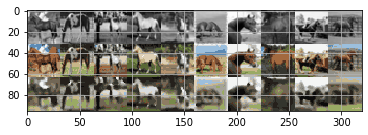

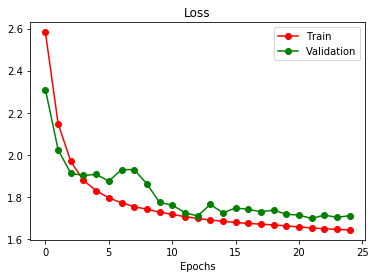

In [0]:
args = AttrDict()
args_dict = {
              'gpu':True, 
              'valid':False, 
              'checkpoint':"", 
              'colours':'./data/colours/colour_kmeans24_cat7.npy', 
              'model':"CNN", 
              'kernel':3,
              'num_filters':32, 
              'learn_rate':0.01, 
              'batch_size':100, 
              'epochs':25, 
              'seed':0,
              'plot':True, 
              'experiment_name': 'colourization_cnn',
              'visualize': False,
              'downsize_input':False,
}
args.update(args_dict)
cnn = train(args)

$
\textbf{Observations:}The\;results\;are\;far\;better\;compared\;to\;regression.We\;can\;see\;the\;colours\;clearly\;compared\;to\;regression\;model.
$

$
Question\;3(a):UNet\;Function
$

In [0]:
class UNet(nn.Module):
    def __init__(self, kernel, num_filters, num_colours, num_in_channels):
        super(UNet, self).__init__()
        padding = kernel // 2

        self.downconv1 = nn.Sequential(
            MyConv2d(num_in_channels, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.MaxPool2d(2),)
        self.downconv2 = nn.Sequential(
            MyConv2d(num_filters, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU(),
            nn.MaxPool2d(2),)

        self.rfconv = nn.Sequential(
            MyConv2d(num_filters*2, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU())

        self.upconv1 = nn.Sequential(
            MyConv2d(num_filters*2*2, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),)
        self.upconv2 = nn.Sequential(
            MyConv2d(num_filters*2, 3, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),)
        self.finalconv = MyConv2d(3+num_in_channels, 24, kernel_size=kernel)

    def forward(self, x):
        self.out1 = self.downconv1(x)
        self.out2 = self.downconv2(self.out1)
        self.out3 = self.rfconv(self.out2)
        self.skip1 = torch.cat((self.out3,self.out2),1)
        self.out4 = self.upconv1(self.skip1)
        self.skip2 = torch.cat((self.out4,self.out1),1)
        self.out5 = self.upconv2(self.skip2)
        self.skip3 = torch.cat((self.out5,x),1)
        self.out_final = self.finalconv(self.skip3)
        return self.out_final

$
Question\;3(b):(Unet\;training)
$

Loading data...
data/cifar-10-batches-py.tar.gz
Transforming data...
Beginning training ...
Epoch [1/25], Loss: 2.4581, Time (s): 0
Epoch [1/25], Val Loss: 2.2807, Val Acc: 21.7%, Time(s): 0
Epoch [2/25], Loss: 1.9592, Time (s): 1
Epoch [2/25], Val Loss: 1.9410, Val Acc: 31.0%, Time(s): 1
Epoch [3/25], Loss: 1.8238, Time (s): 2
Epoch [3/25], Val Loss: 1.8916, Val Acc: 31.8%, Time(s): 2
Epoch [4/25], Loss: 1.7526, Time (s): 3
Epoch [4/25], Val Loss: 1.7812, Val Acc: 35.2%, Time(s): 3
Epoch [5/25], Loss: 1.7028, Time (s): 4
Epoch [5/25], Val Loss: 1.7755, Val Acc: 34.6%, Time(s): 4
Epoch [6/25], Loss: 1.6632, Time (s): 5
Epoch [6/25], Val Loss: 1.7482, Val Acc: 35.8%, Time(s): 5
Epoch [7/25], Loss: 1.6353, Time (s): 5
Epoch [7/25], Val Loss: 1.6952, Val Acc: 37.4%, Time(s): 6
Epoch [8/25], Loss: 1.6112, Time (s): 6
Epoch [8/25], Val Loss: 1.6513, Val Acc: 38.8%, Time(s): 7
Epoch [9/25], Loss: 1.5904, Time (s): 7
Epoch [9/25], Val Loss: 1.6271, Val Acc: 39.6%, Time(s): 8
Epoch [10/25], Lo

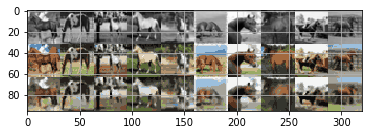

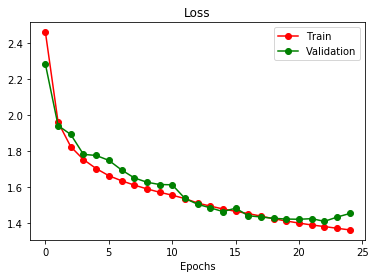

In [0]:
args = AttrDict()
args_dict = {
              'gpu':True, 
              'valid':False, 
              'checkpoint':"", 
              'colours':'./data/colours/colour_kmeans24_cat7.npy', 
              'model':"UNet", 
              'kernel':3,
              'num_filters':32, 
              'learn_rate':0.01, 
              'batch_size':100, 
              'epochs':25, 
              'seed':0,
              'plot':True, 
              'experiment_name': 'colourization_unet',
              'visualize': False,
              'downsize_input':False,
}
args.update(args_dict)
unet_cnn = train(args)

$
\textbf{Observations:}The\;training\;accuracy\;increased\;to\;46\%\;from\;37\%.
\\\implies The\;skip\;connections\;improved\;validation\;loss\;and\;accuracy.
\\\implies Yes\;the\;skip\;connections\;improved\;outputs\;qualitatively.The\;model\;is\;able\;colour\;some\;of\;the\;pixels\;which\;where\;coloured\;wrongly.
\\\implies Reasons\;for\;improvement\;in\;accuracy\;using\;skip\;connections:
\\\implies(1):The\;CNN\;without\;skip\;connections\;is\;quiet\;deep\;so\;the\;gradient\;may\;not\;flow\;to\;the\;earlier\;layers\;i.e\;vanishing\;gradient\;problem.Skip\;connections\;avoid\;vanishing\;gradient\;problem\;by\;directly\;flowing\;the\;gradient\;to\;earlier\;layers.
\\\implies(2):The\;Model\;involves\;downsampling\;in\;earlier\;layers\;so\;some\;of\;the\;features\;may\;be\;lost\;.So\;by\;adding\;skip\;connections\;to\;the\;model\;we\;can\;provide\;some\;the\;features\;to\;the\;next\;layers\;using\;skip\;connections.
$

$
Question\;3(c):batch\;size<100
$

Loading data...
data/cifar-10-batches-py.tar.gz
Transforming data...
Beginning training ...
Epoch [1/25], Loss: 2.0547, Time (s): 1
Epoch [1/25], Val Loss: 1.8194, Val Acc: 34.4%, Time(s): 1
Epoch [2/25], Loss: 1.7815, Time (s): 3
Epoch [2/25], Val Loss: 1.7807, Val Acc: 35.3%, Time(s): 3
Epoch [3/25], Loss: 1.7062, Time (s): 5
Epoch [3/25], Val Loss: 1.7078, Val Acc: 37.2%, Time(s): 5
Epoch [4/25], Loss: 1.6509, Time (s): 6
Epoch [4/25], Val Loss: 1.6322, Val Acc: 40.0%, Time(s): 7
Epoch [5/25], Loss: 1.6071, Time (s): 8
Epoch [5/25], Val Loss: 1.5647, Val Acc: 42.7%, Time(s): 9
Epoch [6/25], Loss: 1.5718, Time (s): 10
Epoch [6/25], Val Loss: 1.5450, Val Acc: 43.1%, Time(s): 10
Epoch [7/25], Loss: 1.5428, Time (s): 12
Epoch [7/25], Val Loss: 1.5177, Val Acc: 44.3%, Time(s): 12
Epoch [8/25], Loss: 1.5181, Time (s): 14
Epoch [8/25], Val Loss: 1.5136, Val Acc: 44.3%, Time(s): 14
Epoch [9/25], Loss: 1.4961, Time (s): 16
Epoch [9/25], Val Loss: 1.4970, Val Acc: 44.9%, Time(s): 16
Epoch [10

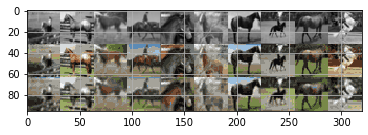

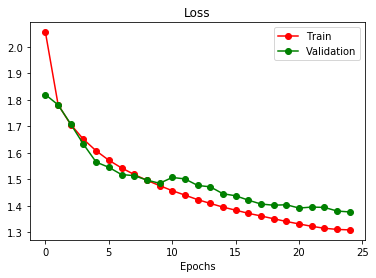

In [0]:
args = AttrDict()
args_dict = {
              'gpu':True, 
              'valid':False, 
              'checkpoint':"", 
              'colours':'./data/colours/colour_kmeans24_cat7.npy', 
              'model':"UNet", 
              'kernel':3,
              'num_filters':32, 
              'learn_rate':0.01, 
              'batch_size':20, 
              'epochs':25, 
              'seed':0,
              'plot':True, 
              'experiment_name': 'colourization_unet',
              'visualize': False,
              'downsize_input':False,
}
args.update(args_dict)
unet_cnn1 = train(args)

$
batch\;size>100
$

Loading data...
data/cifar-10-batches-py.tar.gz
Transforming data...
Beginning training ...
Epoch [1/25], Loss: 2.6113, Time (s): 0
Epoch [1/25], Val Loss: 2.4913, Val Acc: 15.9%, Time(s): 0
Epoch [2/25], Loss: 2.1455, Time (s): 1
Epoch [2/25], Val Loss: 2.0406, Val Acc: 29.0%, Time(s): 1
Epoch [3/25], Loss: 1.9657, Time (s): 2
Epoch [3/25], Val Loss: 2.0144, Val Acc: 28.0%, Time(s): 2
Epoch [4/25], Loss: 1.8739, Time (s): 2
Epoch [4/25], Val Loss: 1.9139, Val Acc: 30.9%, Time(s): 3
Epoch [5/25], Loss: 1.8146, Time (s): 3
Epoch [5/25], Val Loss: 1.8678, Val Acc: 32.2%, Time(s): 3
Epoch [6/25], Loss: 1.7706, Time (s): 4
Epoch [6/25], Val Loss: 1.7798, Val Acc: 35.4%, Time(s): 4
Epoch [7/25], Loss: 1.7286, Time (s): 5
Epoch [7/25], Val Loss: 1.7250, Val Acc: 36.8%, Time(s): 5
Epoch [8/25], Loss: 1.6964, Time (s): 6
Epoch [8/25], Val Loss: 1.6918, Val Acc: 37.7%, Time(s): 6
Epoch [9/25], Loss: 1.6665, Time (s): 7
Epoch [9/25], Val Loss: 1.6588, Val Acc: 39.1%, Time(s): 7
Epoch [10/25], Lo

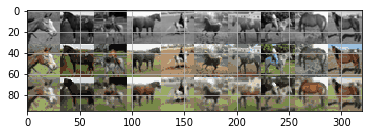

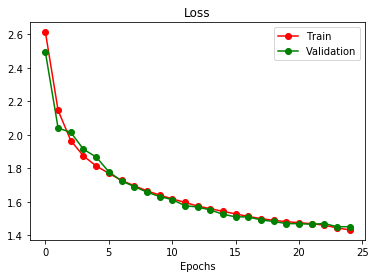

In [0]:
args = AttrDict()
args_dict = {
              'gpu':True, 
              'valid':False, 
              'checkpoint':"", 
              'colours':'./data/colours/colour_kmeans24_cat7.npy', 
              'model':"UNet", 
              'kernel':3,
              'num_filters':32, 
              'learn_rate':0.01, 
              'batch_size':200, 
              'epochs':25, 
              'seed':0,
              'plot':True, 
              'experiment_name': 'colourization_unet',
              'visualize': False,
              'downsize_input':False,
}
args.update(args_dict)
unet_cnn2 = train(args)

$
\textbf{Observations:}\\\implies The\;validation\;loss\;with\;batch\;size=10\;is\;less\;than\;loss\;with\;batch\;size=200.
\\\implies Mini\;batch\;gradient\;descent\;outperforms\;batch\;gradient\;descent.
$

$$
CIFAR-10\;super-resolution
$$

$
Question\;4(a):Resolution\;Difference:There\;is\;no\;difference\;in\;resolutions,but\;downsized\;input\;is\;a\;bit\;blurred.
$

$
Question\;4(b):
Super-Resolution\;with\;CNN
$

Loading data...
data/cifar-10-batches-py.tar.gz
Transforming data...
Beginning training ...


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Epoch [1/25], Loss: 2.9605, Time (s): 0
Epoch [1/25], Val Loss: 2.8539, Val Acc: 15.1%, Time(s): 0
Epoch [2/25], Loss: 2.6572, Time (s): 1
Epoch [2/25], Val Loss: 2.5709, Val Acc: 17.2%, Time(s): 1
Epoch [3/25], Loss: 2.4674, Time (s): 2
Epoch [3/25], Val Loss: 2.4173, Val Acc: 18.5%, Time(s): 2
Epoch [4/25], Loss: 2.3370, Time (s): 3
Epoch [4/25], Val Loss: 2.2989, Val Acc: 22.4%, Time(s): 3
Epoch [5/25], Loss: 2.2225, Time (s): 4
Epoch [5/25], Val Loss: 2.1858, Val Acc: 26.4%, Time(s): 4
Epoch [6/25], Loss: 2.1349, Time (s): 4
Epoch [6/25], Val Loss: 2.1054, Val Acc: 28.1%, Time(s): 5
Epoch [7/25], Loss: 2.0684, Time (s): 5
Epoch [7/25], Val Loss: 2.0525, Val Acc: 29.5%, Time(s): 6
Epoch [8/25], Loss: 2.0167, Time (s): 6
Epoch [8/25], Val Loss: 2.0027, Val Acc: 30.9%, Time(s): 7
Epoch [9/25], Loss: 1.9749, Time (s): 7
Epoch [9/25], Val Loss: 1.9631, Val Acc: 32.1%, Time(s): 8
Epoch [10/25], Loss: 1.9401, Time (s): 8
Epoch [10/25], Val Loss: 1.9286, Val Acc: 33.5%, Time(s): 9
Epoch [1

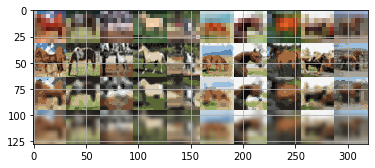

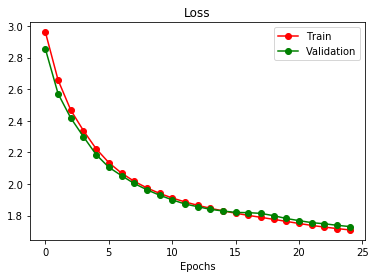

In [0]:
args = AttrDict()
args_dict = {
              'gpu':True, 
              'valid':False, 
              'checkpoint':"", 
              'colours':'./data/colours/colour_kmeans24_cat7.npy', 
              'model':"CNN", 
              'kernel':3,
              'num_filters':32, 
              'learn_rate':0.001, 
              'batch_size':100, 
              'epochs':25, 
              'seed':0,
              'plot':True, 
              'experiment_name': 'super_res_cnn',
              'visualize': False,
              'downsize_input':True,
}
args.update(args_dict)
sr_cnn = train(args)

$
Super\;resolution\;with\;Unet
$

Loading data...
data/cifar-10-batches-py.tar.gz
Transforming data...
Beginning training ...


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Epoch [1/25], Loss: 2.8706, Time (s): 0
Epoch [1/25], Val Loss: 2.7054, Val Acc: 18.6%, Time(s): 0
Epoch [2/25], Loss: 2.5837, Time (s): 1
Epoch [2/25], Val Loss: 2.5163, Val Acc: 24.1%, Time(s): 1
Epoch [3/25], Loss: 2.4015, Time (s): 2
Epoch [3/25], Val Loss: 2.3253, Val Acc: 27.6%, Time(s): 2
Epoch [4/25], Loss: 2.2687, Time (s): 3
Epoch [4/25], Val Loss: 2.1943, Val Acc: 30.7%, Time(s): 3
Epoch [5/25], Loss: 2.1679, Time (s): 4
Epoch [5/25], Val Loss: 2.0971, Val Acc: 33.2%, Time(s): 4
Epoch [6/25], Loss: 2.0885, Time (s): 5
Epoch [6/25], Val Loss: 2.0256, Val Acc: 34.4%, Time(s): 5
Epoch [7/25], Loss: 2.0239, Time (s): 6
Epoch [7/25], Val Loss: 1.9683, Val Acc: 35.7%, Time(s): 6
Epoch [8/25], Loss: 1.9709, Time (s): 7
Epoch [8/25], Val Loss: 1.9236, Val Acc: 37.0%, Time(s): 7
Epoch [9/25], Loss: 1.9271, Time (s): 8
Epoch [9/25], Val Loss: 1.8898, Val Acc: 38.0%, Time(s): 8
Epoch [10/25], Loss: 1.8903, Time (s): 9
Epoch [10/25], Val Loss: 1.8577, Val Acc: 39.0%, Time(s): 9
Epoch [1

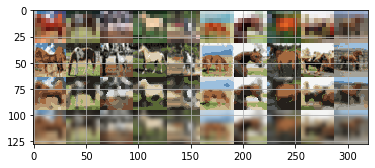

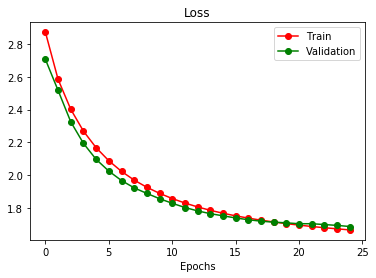

In [0]:
args = AttrDict()
args_dict = {
              'gpu':True, 
              'valid':False, 
              'checkpoint':"", 
              'colours':'./data/colours/colour_kmeans24_cat7.npy', 
              'model':"UNet", 
              'kernel':3,
              'num_filters':32, 
              'learn_rate':0.001, 
              'batch_size':100, 
              'epochs':25, 
              'seed':0,
              'plot':True, 
              'experiment_name': 'super_res_unet',
              'visualize': False,
              'downsize_input':True,
}
args.update(args_dict)
sr_unet = train(args)

$
\textbf{Observations:}
\\\implies Unet\;reconstructs\;the\;background\;pixels\;well\;comparitively\;with\;CNN.
\\\implies Billinear\;interploation\;reconstructs\;the\;image\;pixels\;which\;is\;a\;function\;of\;two\;linear\;functions,whereas\;CNN\;reconstructs\;them\;as\;a\;non\;linear\;function.Hence\;CNN\;is\;able\;to\;reconstruct\;well\;compared\;to\;billinear\;interpolation.
\\\implies Bilinear\;interpolation\;doesn't\;contain\;learnable\;parameters\;as\;CNN.
$

$
Question\;5:
$
$
\\Visualizing\;Intermediate\;Activations
$

$
Question\;5(a):Visualize\;CNN
$

In [0]:
args = AttrDict()
args_dict = {
              'colours':'./data/colours/colour_kmeans24_cat7.npy', 
              'index':0,
              'experiment_name': 'colourization_cnn',
              'downsize_input':False,
}
args.update(args_dict)
plot_activation(args,cnn)

data/cifar-10-batches-py.tar.gz


visualization results are saved to outputs/colourization_cnn/act0


First layer activations of CNN


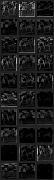

Second layer activations of CNN


Third layer activations of CNN


Fourth layer activations of CNN


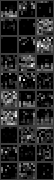

Fifth layer activations of CNN


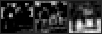

In [0]:
from IPython.display import Image, display
print('First layer activations of CNN')
display(Image('/content/cs6360/a2/outputs/colourization_cnn/act0/conv1_out_0.png'))
print('Second layer activations of CNN')
display(Image('/content/cs6360/a2/outputs/colourization_cnn/act0/conv2_out_0.png'))
print('Third layer activations of CNN')
display(Image('/content/cs6360/a2/outputs/colourization_cnn/act0/conv3_out_0.png'))
print('Fourth layer activations of CNN')
display(Image('/content/cs6360/a2/outputs/colourization_cnn/act0/conv4_out_0.png'))
print('Fifth layer activations of CNN')
display(Image('/content/cs6360/a2/outputs/colourization_cnn/act0/conv5_out_0.png'))

$
\\\textbf{Observations:}The\;first\;layer\;almost\;retains\;the\;image\;features.This\;layer\;extracts\;basic\;information\;like\;horizontal\;and\;vertical\;edges.
\\\implies The\;next\;layers\;extracts\;high\;level\;features\;like\;borders\;corners\;and\;angles.
$

$
Question\;5(b):Visualize\;Unet
$

In [0]:
args = AttrDict()
args_dict1 = {
              'colours':'./data/colours/colour_kmeans24_cat7.npy', 
              'index':0,
              'experiment_name': 'colourization_unet',
              'downsize_input':False,
}
args.update(args_dict1)
plot_activation(args, unet_cnn)

data/cifar-10-batches-py.tar.gz


visualization results are saved to outputs/colourization_unet/act0


First layer activations of UNet


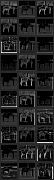

Second layer activations of UNet


Third layer activations of UNet


Fourth layer activations of UNet


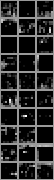

Fifth layer activations of UNet


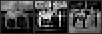

In [0]:
print('First layer activations of UNet')
display(Image('/content/cs6360/a2/outputs/colourization_unet/act0/conv1_out_0.png'))
print('Second layer activations of UNet')
display(Image('/content/cs6360/a2/outputs/colourization_unet/act0/conv2_out_0.png'))
print('Third layer activations of UNet')
display(Image('/content/cs6360/a2/outputs/colourization_unet/act0/conv3_out_0.png'))
print('Fourth layer activations of UNet')
display(Image('/content/cs6360/a2/outputs/colourization_unet/act0/conv4_out_0.png'))
print('Fifth layer activations of UNet')
display(Image('/content/cs6360/a2/outputs/colourization_unet/act0/conv5_out_0.png'))

$
Observations:The\;upsampled\;activations\;are\;more\;clear\;compared\;to\;CNN.Because.\;the\;skipped\;layer\;connections\;the\;upsampled\;layers\;contains\;better\;information\;about\;the\;initial\;features.
$

$
Question\;5(c):Visualize\;super-resolution
$

In [0]:
args = AttrDict()
args_dict = {
              'colours':'./data/colours/colour_kmeans24_cat7.npy', 
              'index':0,
              'experiment_name': 'super_res_unet',
              'downsize_input':True,
}
args.update(args_dict)
plot_activation(args, sr_unet)

data/cifar-10-batches-py.tar.gz


visualization results are saved to outputs/super_res_unet/act0


First layer activations of Super Resolution UNet


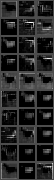

Second layer activations of Super Resolution UNet


Third layer activations of Super Resolution UNet


Fourth layer activations of Super Resolution UNet


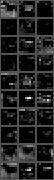

Fifth layer activations of Super Resolution UNet


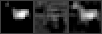

In [0]:
print('First layer activations of Super Resolution UNet')
display(Image('/content/cs6360/a2/outputs/super_res_unet/act0/conv1_out_0.png'))
print('Second layer activations of Super Resolution UNet')
display(Image('/content/cs6360/a2/outputs/super_res_unet/act0/conv2_out_0.png'))
print('Third layer activations of Super Resolution UNet')
display(Image('/content/cs6360/a2/outputs/super_res_unet/act0/conv3_out_0.png'))
print('Fourth layer activations of Super Resolution UNet')
display(Image('/content/cs6360/a2/outputs/super_res_unet/act0/conv4_out_0.png'))
print('Fifth layer activations of Super Resolution UNet')
display(Image('/content/cs6360/a2/outputs/super_res_unet/act0/conv5_out_0.png'))

$
Observations:Each\;layers\;trys\;regress\;the\;edges,corners\;and\;borders\;of\;blurred\;image\;upto\;some\;extent.
$

$
\\\implies\textbf{The hyperparameters which can be tuned :}Kernel\;size,No\;of\;filters,learning\;rate,batch\;size,epochs.
$
$
\\\textbf{Question 6(a):}Hyperparamter\;tuning(Learning\;rate=0.1,No\;of\;filters=64)
$

Loading data...
data/cifar-10-batches-py.tar.gz
Transforming data...
Beginning training ...
Epoch [1/25], Loss: 2.1624, Time (s): 0
Epoch [1/25], Val Loss: 2.7165, Val Acc: 19.3%, Time(s): 1
Epoch [2/25], Loss: 1.7717, Time (s): 1
Epoch [2/25], Val Loss: 1.7010, Val Acc: 36.5%, Time(s): 2
Epoch [3/25], Loss: 1.6779, Time (s): 3
Epoch [3/25], Val Loss: 1.6651, Val Acc: 39.6%, Time(s): 3
Epoch [4/25], Loss: 1.6338, Time (s): 4
Epoch [4/25], Val Loss: 1.6271, Val Acc: 40.5%, Time(s): 4
Epoch [5/25], Loss: 1.6029, Time (s): 5
Epoch [5/25], Val Loss: 1.5770, Val Acc: 41.8%, Time(s): 5
Epoch [6/25], Loss: 1.5789, Time (s): 6
Epoch [6/25], Val Loss: 1.5820, Val Acc: 41.1%, Time(s): 6
Epoch [7/25], Loss: 1.5598, Time (s): 7
Epoch [7/25], Val Loss: 1.5666, Val Acc: 41.4%, Time(s): 7
Epoch [8/25], Loss: 1.5435, Time (s): 8
Epoch [8/25], Val Loss: 1.5604, Val Acc: 41.1%, Time(s): 9
Epoch [9/25], Loss: 1.5265, Time (s): 10
Epoch [9/25], Val Loss: 1.5519, Val Acc: 40.8%, Time(s): 10
Epoch [10/25], 

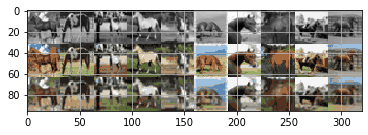

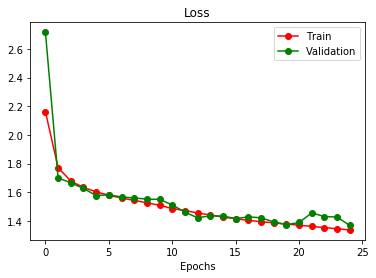

In [0]:
args = AttrDict()
args_dict = {
              'gpu':True, 
              'valid':False, 
              'checkpoint':"", 
              'colours':'./data/colours/colour_kmeans24_cat7.npy', 
              'model':"UNet", 
              'kernel':3,
              'num_filters':64, 
              'learn_rate':0.1, 
              'batch_size':100, 
              'epochs':25, 
              'seed':0,
              'plot':True, 
              'experiment_name': 'colourization_unet',
              'visualize': False,
              'downsize_input':False,
}
args.update(args_dict)
unet_cnn_tuned = train(args)

$
\textbf{Observations:}The\;accuracy\;goes\;to\;high\;values\;as\;the\;learning\;rate\;increased\;to\;0.1\;and];filter\;size\;is\;increased\;by\;a\;factor\;2.
$

$
6(b):\textbf{Maxpool and Relu ordering}:The\;ordering\;of\;Relu\;and\;max\;pooling\;doesn't\;matter\;because\;both\;are\;max()\;operations.
\\\implies No\;of\;operations\;are\;different\;in\;two\;
cases.
$

$
6(c):\textbf{Loss Function and evaluation metrics:}High-quality\;images\;an\;be\;generated\;by \;defining
\;and\;optimizing\;perceptual\;loss\;functions\;based\;on \;high-level\;features\;extracted\;from\;pretrained \;networks
$

$
6(d):\textbf{Different sizes of test images:}The\;test\;size\;input\;is\;more\;than\;the\;train\;size\;input\;we\;are\;going\;to\;use\;an\;image\;proccessing(binomial filters)\;downsampling\;technique\;to\;reduce\;the\;size\;of\;test\;image.
\\\implies We\;can\;restore\;the\;size\;of\;image\;by\;using\;another\;upsampling\;method\;in\;image\;processing(Binomial filters).
$